In [46]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 로드

In [47]:
df_seoul_info = pd.read_csv("./data/seoul_info.csv", low_memory=False)
df_seoul_info

,NO,시군구,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세금(만원),건축년도,도로명,계약기간,계약구분,갱신요구권 사용,종전계약 보증금(만원),종전계약 월세(만원),주택유형,key 값,실거래(만원),보증금/실거래가
0,6,서울특별시 강남구 역삼동,전세,37.49,202512,31,"25,000",0,2004.0,역삼로4길 16,202601~202801,갱신,-,"24,000",0,오피스텔,서울특별시 강남구 역삼동역삼로4길 16,20000,1.250000
1,7,서울특별시 중구 중림동,전세,68.04,202512,31,"59,000",0,2006.0,청파로 464,202602~202702,신규,-,NaN,NaN,오피스텔,서울특별시 중구 중림동청파로 464,74900,0.787717
2,29,서울특별시 동대문구 용두동,전세,23.10,202512,31,"23,000",0,2019.0,청계천로 505,202601~202602,갱신,-,"23,000",0,오피스텔,서울특별시 동대문구 용두동청계천로 505,17000,1.352941
3,30,서울특별시 동대문구 용두동,전세,40.42,202512,31,"44,000",0,2025.0,고산자로 420,202601~202801,신규,-,NaN,NaN,오피스텔,서울특별시 동대문구 용두동고산자로 420,53420,0.823662
4,35,서울특별시 동대문구 신설동,전세,27.78,202512,31,"31,000",0,2023.0,왕산로 18,202601~202801,갱신,사용,"30,000",0,오피스텔,서울특별시 동대문구 신설동왕산로 18,26000,1.192308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175178,132219,서울특별시 성북구 정릉동,전세,83.28,202501,1,"11,000",0,1995.0,서경로 23,202501~203001,신규,-,NaN,NaN,연립다세대,서울특별시 성북구 정릉동서경로 23,18500,0.594595
175179,132221,서울특별시 송파구 문정동,전세,42.63,202501,1,"7,000",0,1990.0,새말로15길 17-8,202510~202710,갱신,-,"7,000",0,연립다세대,서울특별시 송파구 문정동새말로15길 17-8,28000,0.250000
175180,132231,서울특별시 광진구 자양동,전세,47.94,202501,1,"26,000",0,2014.0,자양로3가길 7-12,202508~202708,갱신,-,"26,000",0,연립다세대,서울특별시 광진구 자양동자양로3가길 7-12,53000,0.490566
175181,132241,서울특별시 서초구 방배동,전세,26.62,202501,1,"38,000",0,2020.0,방배천로30길 10,202502~202602,갱신,사용,"38,000",0,연립다세대,서울특별시 서초구 방배동방배천로30길 10,45000,0.844444


##### [참고] 컬럼별 값들 확인
    # 0. NO : 각 레코드별 고유 인덱스 - 결측치 있는 레코드 삭제 후 인덱스 재설정
    # 1. 시군구 : 서울특별시 xx구 xx동 - ' '로 split해서 '구', '동'을 새 컬럼으로 추가
    # 2. 전월세구분 : 100% 전세니까 삭제
    # 3. 전용면적(㎡) : float 형
    # 4. 계약년월 : int 형 숫자 202501 ~ 202512. 전부 2025년에 계약을 한 주택들
    # 5. 계약일 : 필요없으니 삭제
    # 6. 보증금(만원) : 의외로 숫자형이 아님. str -> int 형 변환
    # 7. 월세금(만원) : 전부 '전세'이므로 값이 모두 0. 삭제
    # 8. 건축년도 : Null 값이 들어간 540개 레코드는 삭제. Not Null 값 중 .0 아닌 건 없으니 float -> int 형 변환
    # 9. 도로명 : 필요없으니 삭제
    # 10. 계약기간 : yyyymm~yyyymm 형식의 str. 전부 2025년 혹은 2026년에 시작하는 계약
    # 11. 계약구분 : 신규 약 9만여 개, 갱신 약 7만여 개, '-' 약 1만여 개. '-'는 신고 누락인듯
    # 12. 갱신요구권 사용 : 사용 or '-'. 필요없으니 삭제
    # 13. 종전계약 보증금(만원) : Null 값이 10만여 개 & 전세사기 위험도와 관련이 적은 컬럼이라 생각되어 삭제
    # 14. 종전계약 월세(만원) : Null 값이 10만여 개 & 전세사기 위험도와 관련이 적은 컬럼이라 생각되어 삭제
    # 15. 주택유형 : 아파트 13만 여개, 연립다세대 2만 여개, 오피스텔 1만 5천여 개.
    # 16. key 값 : 1. 시군구 + 9.도로명 형태. 필요없으니 삭제
    # 17. 실거래(만원) : 실거래가
    # 18. 보증금/실거래가 : 1 이상인 값 6500개, 2 이상인 값 300개(?), max값 6.4444(???)

## 컬럼별 결측치 비율 확인

In [48]:
# 컬럼별 결측치 비율 확인
print(df_seoul_info.isna().mean().sort_values(ascending=False))
print(df_seoul_info['종전계약 보증금(만원)'])

종전계약 보증금(만원)    0.586472
종전계약 월세(만원)     0.586472
건축년도            0.003082
전월세구분           0.000000
시군구             0.000000
NO              0.000000
전용면적(㎡)         0.000000
보증금(만원)         0.000000
월세금(만원)         0.000000
계약일             0.000000
계약년월            0.000000
계약기간            0.000000
도로명             0.000000
갱신요구권 사용        0.000000
계약구분            0.000000
주택유형            0.000000
key 값           0.000000
실거래(만원)         0.000000
보증금/실거래가        0.000000
dtype: float64
0         24,000
1            NaN
2         23,000
3            NaN
4         30,000
           ...  
175178       NaN
175179     7,000
175180    26,000
175181    38,000
175182       NaN
Name: 종전계약 보증금(만원), Length: 175183, dtype: object


## 필요한 데이터 가공하기

In [ ]:
# 보증금, 실거래가 문자열 → float 변환
df_seoul_info['보증금(만원)'] = df_seoul_info['보증금(만원)'].astype(str).str.replace(",", "").astype(float)
df_seoul_info['실거래(만원)'] = df_seoul_info['실거래(만원)'].astype(str).str.replace(",", "").astype(float)

# 건물 나이 계산
current_year = datetime.now().year
df_seoul_info['건물나이'] = current_year - df_seoul_info['건축년도']

# 전세가율 계산 (보증금 / 실거래가)
df_seoul_info['전세가율'] = df_seoul_info['보증금(만원)'] / df_seoul_info['실거래(만원)']


df = df_seoul_info[['보증금(만원)', '실거래(만원)', '건물나이', '보증금/실거래가', '전세가율', '전용면적(㎡)', '계약년월']].copy()
df = df.dropna()  # 결측치 제거

# 시군구에서 구, 동 추출
df['구'] = df_seoul_info['시군구'].str.split().str[1]
df['동'] = df_seoul_info['시군구'].str.split().str[-1]
df['주택유형'] = df_seoul_info['주택유형']

# 동 + 주택유형별 평균 전세가율
avg_ratio = df.groupby(['동', '주택유형'])['보증금/실거래가'].mean().reset_index()
avg_ratio.rename(columns={'보증금/실거래가': '평균_전세가율'}, inplace=True)


# 병합 후 상대비 계산
df = df.merge(avg_ratio, on=['동', '주택유형'], how='left')
df['전세가율_상대비'] = df['보증금/실거래가'] / df['평균_전세가율']

avg_deposit = df.groupby(['동', '주택유형'])['보증금(만원)'].mean().reset_index()
avg_deposit.rename(columns={'보증금(만원)': '평균보증금(만원)'}, inplace=True)

df = df.merge(avg_deposit, on=['동', '주택유형'], how='left')
df['보증금_상대비'] = df['보증금(만원)'] / df['평균보증금(만원)']

maxratio = df['전세가율_상대비'].dropna().max()
upper = maxratio + 1e-9  # max가 경계값일 때 cut 누락 방지

df['전세가율_구간'] = pd.cut(
    df['전세가율_상대비'],
    bins=[0, 0.90, 1.05, 1.20, upper],
    labels=['안정(<0.90)', '적정(0.90~1.05)', '주의(1.05~1.20)', '위험(>=1.20)'],
    include_lowest=True
)

df['건물나이_구간'] = pd.cut(
    df['건물나이'],
    bins=[0, 10, 25, df['건물나이'].max()],
    labels=['신축(≤10)', '중간(11~25)', '노후(≥26)'],
    include_lowest=True
)

,보증금(만원),실거래(만원),건물나이,보증금/실거래가,전세가율,전용면적(㎡),계약년월,구,동,주택유형,평균_전세가율,전세가율_상대비,평균보증금(만원),보증금_상대비,전세가율_구간,건물나이_구간
0,25000.0,20000.0,22.0,1.250000,1.250000,37.49,202512,강남구,역삼동,오피스텔,0.998880,1.251402,25359.829193,0.985811,위험(>=1.20),중간(11~25)
1,59000.0,74900.0,20.0,0.787717,0.787717,68.04,202512,중구,중림동,오피스텔,0.861672,0.914173,26248.708609,2.247730,적정(0.90~1.05),중간(11~25)
2,23000.0,17000.0,7.0,1.352941,1.352941,23.10,202512,동대문구,용두동,오피스텔,0.828159,1.633674,17054.820755,1.348592,위험(>=1.20),신축(≤10)
3,44000.0,53420.0,1.0,0.823662,0.823662,40.42,202512,동대문구,용두동,오피스텔,0.828159,0.994570,17054.820755,2.579916,적정(0.90~1.05),신축(≤10)
4,31000.0,26000.0,3.0,1.192308,1.192308,27.78,202512,동대문구,신설동,오피스텔,0.961732,1.239750,21727.446809,1.426767,위험(>=1.20),신축(≤10)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174638,11000.0,18500.0,31.0,0.594595,0.594595,83.28,202501,성북구,정릉동,연립다세대,0.799226,0.743963,16811.294118,0.654322,안정(<0.90),노후(≥26)
174639,7000.0,28000.0,36.0,0.250000,0.250000,42.63,202501,송파구,문정동,연립다세대,0.761575,0.328267,27522.371681,0.254339,안정(<0.90),노후(≥26)
174640,26000.0,53000.0,12.0,0.490566,0.490566,47.94,202501,광진구,자양동,연립다세대,0.444631,1.103311,27475.077259,0.946312,주의(1.05~1.20),중간(11~25)
174641,38000.0,45000.0,6.0,0.844444,0.844444,26.62,202501,서초구,방배동,연립다세대,0.596847,1.414842,37409.708520,1.015779,위험(>=1.20),신축(≤10)


# 이상치 유무 파악

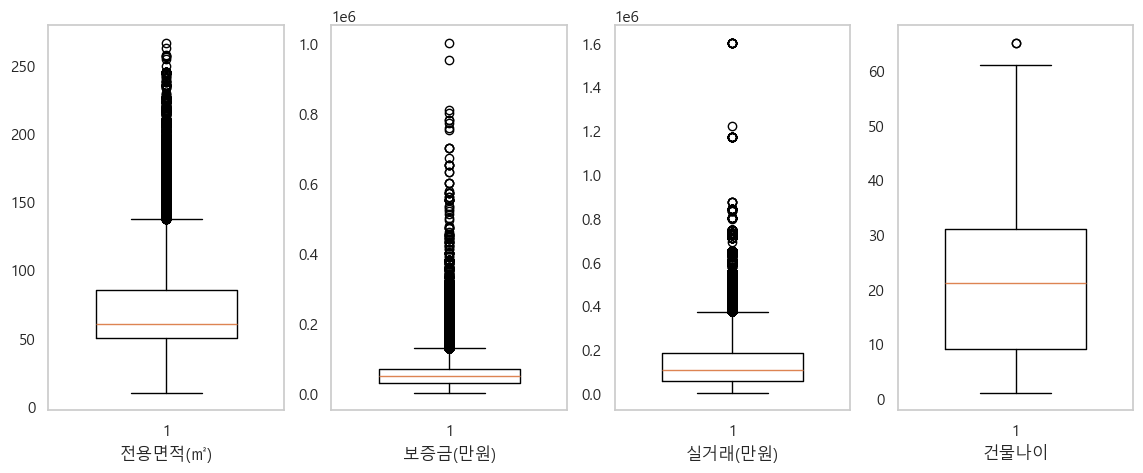

In [58]:
# 이상치 유무 파악
fig, ax = plt.subplots(1, 4, figsize=(14, 5))

ax[0].boxplot([df['전용면적(㎡)']], widths=0.6)
ax[0].set_xlabel('전용면적(㎡)')
ax[0].grid()

ax[1].boxplot([df['보증금(만원)']], widths=0.6)
ax[1].set_xlabel('보증금(만원)')
ax[1].grid()

ax[2].boxplot([df['실거래(만원)']], widths=0.6)
ax[2].set_xlabel('실거래(만원)')
ax[2].grid()

ax[3].boxplot([df['건물나이']], widths=0.6)
ax[3].set_xlabel('건물나이')
ax[3].grid()

plt.show()

In [60]:
# IQR (Interquartile Range): 제3사분위수(Q3)에서 제1사분위수(Q1)를 뺀 값으로, 상자의 길이를 결정
# 수염(Whiskers)의 끝: 보통 Q1 - 1.5 * IQR 와 Q3 + 1.5 * IQR 범위 내의 최소값/최대값
df[df['건물나이'] > 63]['건물나이'].values
# '건축년도'의 이상치 발견 : 1961년 2개

array([65., 65.])

# 시각화

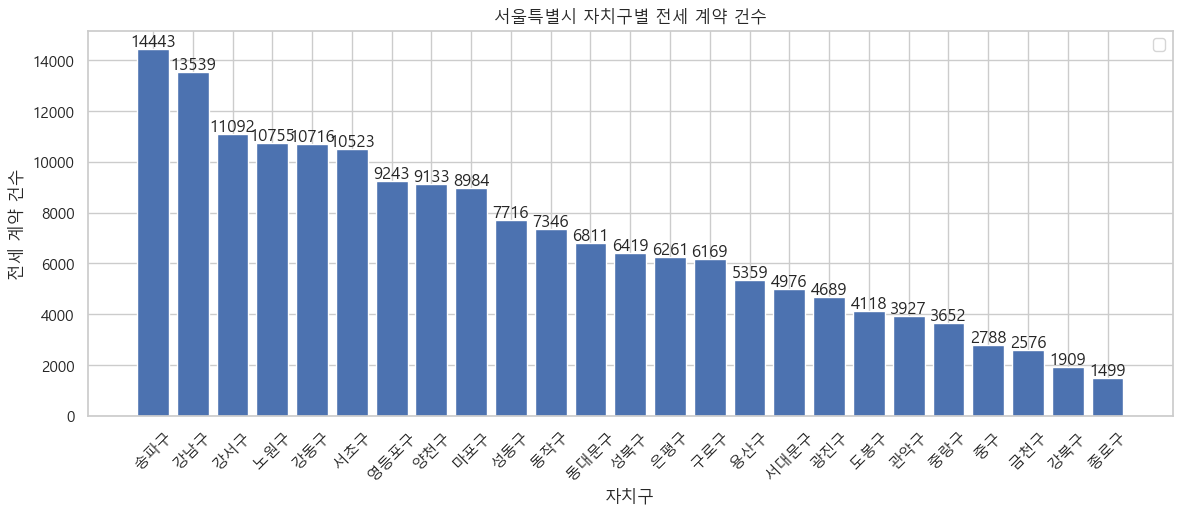

In [63]:
# 1. Bar : 서울특별시 자치구별 전세 계약 건수
fig = plt.figure(figsize=(14, 5))

plt.bar(df.groupby('구')['건물나이'].count().sort_values(ascending=False).index,\
        df.groupby('구')['건물나이'].count().sort_values(ascending=False).values)

for i, val in enumerate(df.groupby('구')['건물나이'].count().sort_values(ascending=False).values):
    # x축 위치, y축 위치, 텍스트, 텍스트 정렬(위치)
    plt.text(i, val + 100, str(val), ha='center')

plt.title('서울특별시 자치구별 전세 계약 건수')
plt.xlabel('자치구')
plt.ylabel('전세 계약 건수')
plt.xticks(rotation=45)
plt.legend()
plt.show()


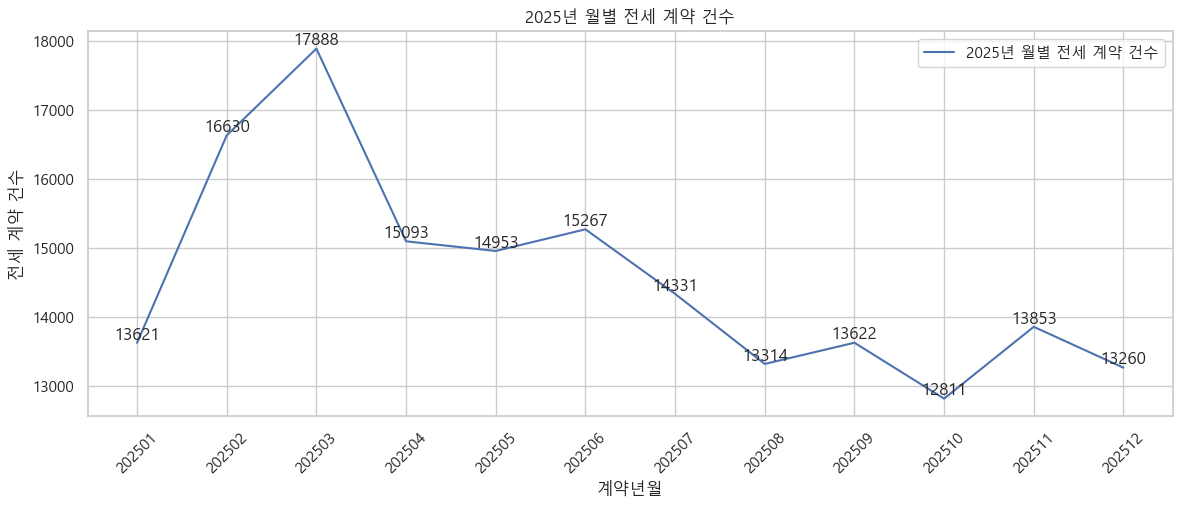

In [66]:
# 2. Line : 2025년 월별 전세 계약 건수
fig = plt.figure(figsize=(14, 5))
plt.plot(df.groupby('계약년월')['건물나이'].count().index.astype(str),\
         df.groupby('계약년월')['건물나이'].count().values, label='2025년 월별 전세 계약 건수')

for i, val in enumerate(df.groupby('계약년월')['건물나이'].count().values):
    # x축 위치, y축 위치, 텍스트, 텍스트 정렬(위치)
    plt.text(i, val + 50, str(val), ha='center')

plt.title('2025년 월별 전세 계약 건수')
plt.xlabel('계약년월')
plt.ylabel('전세 계약 건수')
plt.xticks(
    ticks=range(len(df.groupby('계약년월')['건물나이'].count().index)),
    labels=df.groupby('계약년월')['건물나이'].count().index.astype(str),
    rotation=45,
    # ha='right'
)

plt.legend()
plt.show()

<Axes: >

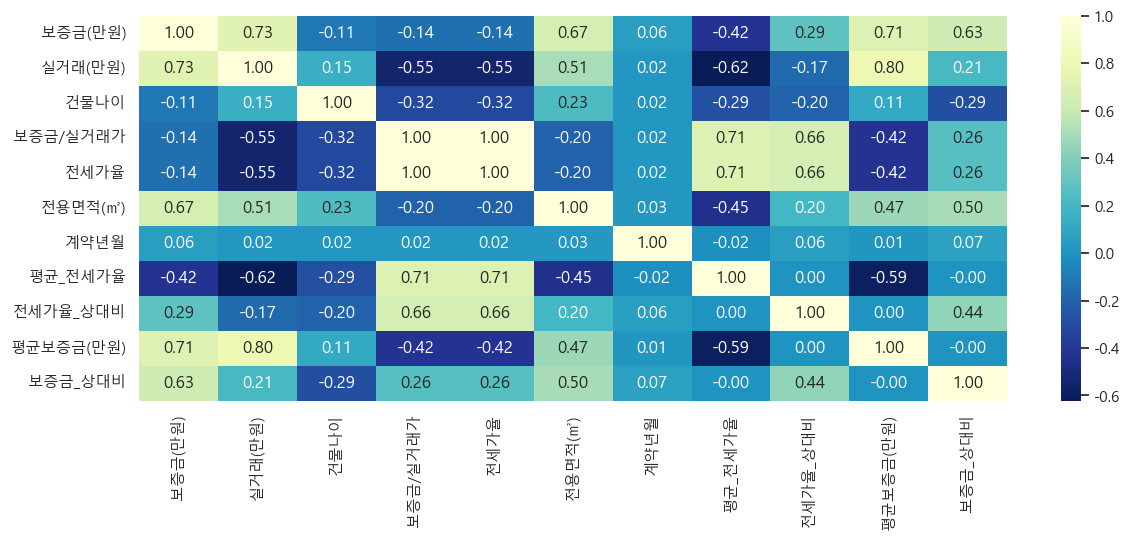

In [68]:
#3. Heatmap : 컬럼 간의 상관 계수 파악
corr_matrix = df.corr(numeric_only=True)

fig = plt.figure(figsize=(14, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu_r')

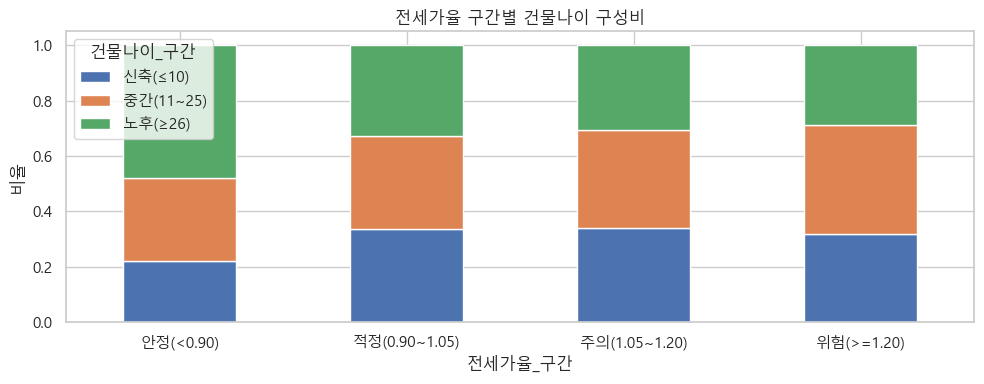

In [73]:
df['건물나이_구간'] = pd.cut(
    df['건물나이'],
    bins=[0, 10, 25, df['건물나이'].max()],
    labels=['신축(≤10)', '중간(11~25)', '노후(≥26)'],
    include_lowest=True
)

age_ratio_by_jeonse = pd.crosstab(  # crosstab은 글자 중복현상 때문에 사용
    df['전세가율_구간'],
    df['건물나이_구간'],
    normalize='index'
).fillna(0)

age_ratio_by_jeonse.plot(kind='bar', stacked=True, figsize=(10,4))
plt.title('전세가율 구간별 건물나이 구성비')
plt.xlabel('전세가율_구간')
plt.ylabel('비율')
plt.xticks(rotation=0)
plt.tight_layout()  # 이것도 시각화 할 때 figsize 늘려놓고 여백 남는거 맞출 때 사용
plt.show()


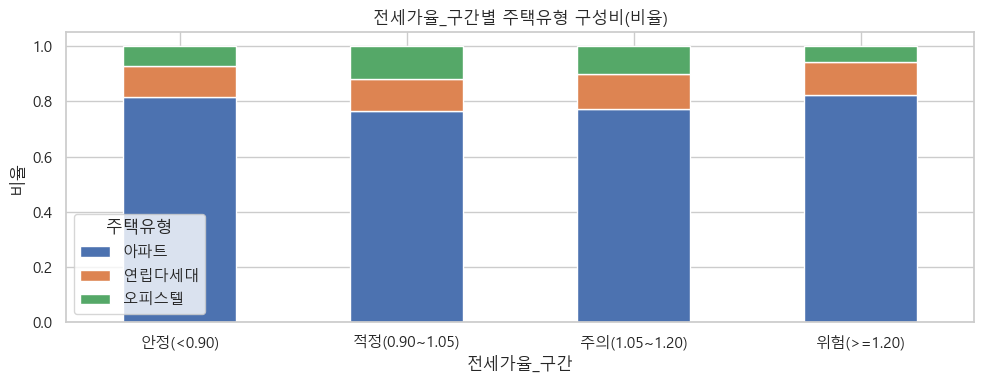

In [74]:
# 3) (시각화) 주택유형

type_ratio_by_bin = pd.crosstab(
    df['전세가율_구간'],
    df['주택유형'],
    normalize='index'   
).fillna(0)

type_ratio_by_bin.plot(kind='bar', stacked=True, figsize=(10,4))
plt.title('전세가율_구간별 주택유형 구성비(비율)')
plt.xlabel('전세가율_구간')
plt.ylabel('비율')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

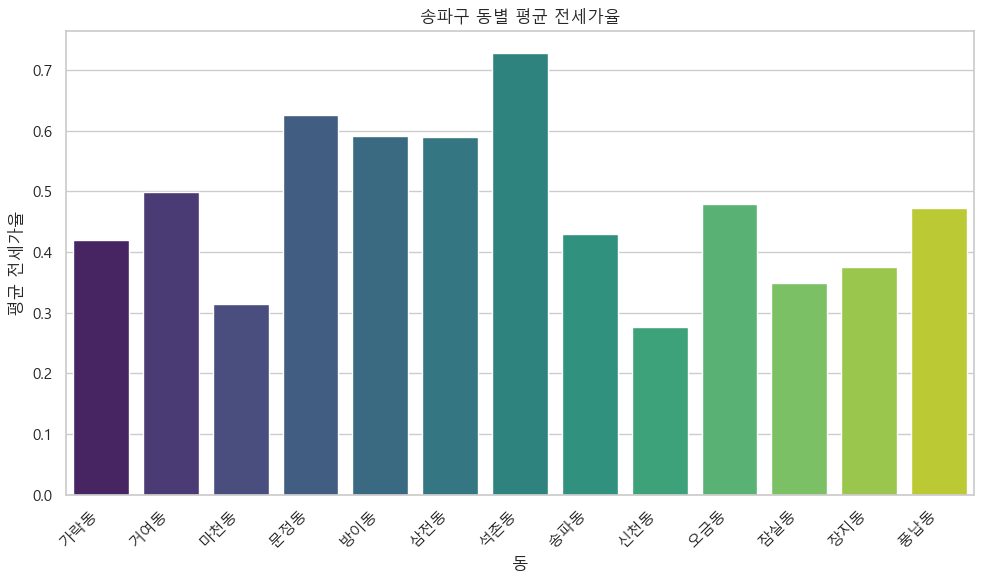

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

df_gangnam = df[df['구'] == '송파구'].groupby('동')['평균_전세가율'].mean().reset_index()

# 그래프
plt.figure(figsize=(10,6))
sns.barplot(data=df_gangnam, x='동', y='평균_전세가율', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel("동")
plt.ylabel("평균 전세가율")
plt.title("송파구 동별 평균 전세가율")
plt.tight_layout()
plt.show()

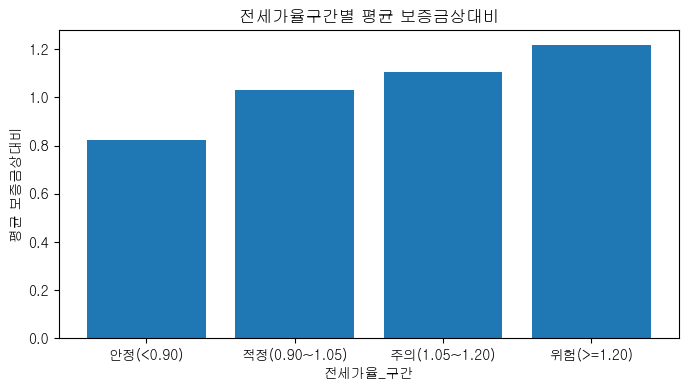

In [ ]:
from matplotlib import font_manager as fm
import warnings
import matplotlib.pyplot as plt
import matplotlib

warnings.filterwarnings('ignore')
font_path = 'C:\Windows\Fonts\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

risk_trend = (df.groupby('전세가율_구간')[['보증금_상대비', '건물나이']]
                .mean()
                .round(4))

plt.figure(figsize=(8,4))
plt.bar(risk_trend.index.astype(str), risk_trend['보증금_상대비'])
plt.title('전세가율구간별 평균 보증금상대비')
plt.xlabel('전세가율_구간')
plt.ylabel('평균 보증금상대비')
plt.xticks(rotation=0)
plt.show()